<a href="https://colab.research.google.com/github/rubyvanrooyen/ARIWS-Cookbook/blob/main/2-Flagging_and_calibration/Basic_calibration_recipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARIWS notebook with sample MeerKAT data using CASA

See the [CASA installation](https://casa.nrao.edu/casadocs/casa-5.6.0/introduction/casa6-installation-and-usage) page for information on the CASA with Jupiter notebooks and Colab
Example code for this notebook can be found on [CASA6_demo.ipynb](https://go.nrao.edu/casa6)

Refer to the [MeerKAT Cookbook](https://github.com/ska-sa/MeerKAT-Cookbook) for information related to archive data access and tokens, as well as the MeerKAT `katdal` software package.


## CASA workspace installation

In [ ]:
print("installing pre-requisite packages...")
!apt-get install -y libgfortran3

Google colab upgraded default python for runtime environment to 3.7 in Feb 2021.
At 7 May 2021, no wheel exists for casatools and casatasks installation, using CASA suggested install of pre-release version for 3.7 and 3.8.

Check current python version

In [2]:
!python --version

Python 3.7.10


See if a wheel exist for casatools installation

https://casa.nrao.edu/casa_obtaining.shtml and     
https://casa.nrao.edu/casadocs/latest/usingcasa/obtaining-and-installing

If a wheel exists for this version of python, add the code block as per example (for 3.6)   
```
!pip install --index-url https://casa-pip.nrao.edu/repository/pypi-casa-release/simple casaplotms==1.0.24
```

No wheel currently available for 3.7, notes on work around for >=3.7    
https://www.magclouds.org/casa6-docker/html/install/usage.html    
(https://pypi.org/project/casa6-install/)

In [3]:
!git clone https://github.com/r-xue/casa6-docker.git

Cloning into 'casa6-docker'...
remote: Enumerating objects: 316, done.
remote: Counting objects: 100% (316/316), done.
remote: Compressing objects: 100% (172/172), done.
remote: Total 316 (delta 136), reused 299 (delta 123), pack-reused 0
Receiving objects: 100% (316/316), 10.21 MiB | 27.43 MiB/s, done.
Resolving deltas: 100% (136/136), done.


In [4]:
!ln -s /content/casa6-docker/casa6_install/casa6_install.py casa6_install.py

In [ ]:
!python casa6_install.py

In [6]:
import os

print("building config files...")
!mkdir -p ~/.casa
!echo home, datapath = \'/content/\', [\'/content/\'] > ~/.casa/toolrc.py
!cat ~/.casa/toolrc.py

print('complete')

# check installation
import casatasks
from casatasks import listobs

building config files...
home, datapath = '/content/', ['/content/']
complete
Creating a new telemetry file


Telemetry initialized. Telemetry will send anonymized usage statistics to NRAO.
You can disable telemetry by adding the following line to the config.py file in your rcdir (e.g. ~/.casa/config.py):
telemetry_enabled = False


In [ ]:
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay

print(os.getenv('DISPLAY'))

import pyvirtualdisplay

_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

print(os.getenv('DISPLAY'))

# Mounting Google drive locally
Mount your Google Drive on your runtime using an authorization code

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Tutorial continuous the processing of the `ngc3621.ms` dataset.   
Remember to first flag the data using the [Inspect_and_flagging_calibrators.ipynb](https://github.com/rubyvanrooyen/ARIWS-Cookbook/blob/main/2-Flagging_and_calibration/Inspect_and_flagging_calibrators.ipynb) notebook.

Create symbolic link in the `/content` top layer folder for each processing.
Use the appropriate path to the example dataset you copied to your drive

In [9]:
example_data = "/content/drive/MyDrive/ARIWS\ public\ datasets/output/ngc3621_flagged.ms.tar.gz"

In [10]:
!ln -s {example_data}

## Data from MeerKAT archive

Unpack MeerKAT example data file

In [11]:
datafile = "ngc3621_flagged.ms.tar.gz"

In [ ]:
!tar -xvzf {datafile}

In [14]:
msfile = "ngc3621.ms"
listobs(vis=msfile)
print(os.popen("cat casa-*.log").read())

2021-05-08 18:01:08	INFO	::casa	
2021-05-08 18:01:09	INFO	::casa	CASA Version 6.1.2.7
2021-05-08 18:01:09	INFO	::casa	
2021-05-08 18:01:09	INFO	::casa	Telemetry log file: /root/.casa/casastats-6.1.2.7-242ac1c02-20210508-180109.log
2021-05-08 18:01:09	INFO	::casa	Checking telemetry submission interval
2021-05-08 18:01:09	INFO	::casa	Creating a new telemetry time stamp file./root/.casa/telemetry-242ac1c02.stamp
2021-05-08 18:01:09	INFO	::casa	Telemetry submit interval not reached. Not submitting data.
2021-05-08 18:01:09	INFO	::casa	Next telemetry data submission in: 6 days, 23:59:59.998338
2021-05-08 18:06:49	INFO	listobs::::casa	##########################################
2021-05-08 18:06:49	INFO	listobs::::casa	##### Begin Task: listobs            #####
2021-05-08 18:06:49	INFO	listobs::::casa	listobs( vis='ngc3621.ms', selectdata=True, spw='', field='', antenna='', uvrange='', timerange='', correlation='', scan='', intent='', feed='', array='', observation='', verbose=True, listfile='

# Calibrating MeerKAT data

CASA task information for calibration functions can be found on the CASA documentation page:   
https://casa.nrao.edu/casadocs/casa-6.1.0/global-task-list

CASA visualisation of measurement set and calibration tables:    
https://casa.nrao.edu/casadocs/casa-5-1.2/data-examination-and-editing/using-plotms-to-plot-and-edit-visibilities-and-calibration-tables    
and    
https://casadocs.readthedocs.io/en/latest/api/tt/casatasks.visualization.plotms.html

In [15]:
from IPython.display import Image
import casaplotms
from casaplotms import plotms
import casatasks
from casatasks import fixvis, clearcal, setjy, rmtables, gaincal, bandpass, fluxscale, applycal

In [16]:
msfile = 'ngc3621.ms'
prefix='ngc3621'
target='NGC3621'
g_cal='1117-248'
b_cal='0408-65'
f_cal='0408-65'
ref_ant='m003'

### [Optional] W correction

In [17]:
# remember to check the casa log file as you go
fixvis(vis=msfile, outputvis=prefix+'_fixvis.ms')

True

In [18]:
msfile = prefix+'_fixvis.ms'
prefix = prefix+'_fixvis'
print(msfile)
print(prefix)

ngc3621_fixvis.ms
ngc3621_fixvis


### Basics calibration steps

In [19]:
clearcal(vis=msfile)

### Convert correlation coefficients to absolute flux densities

In [20]:
import numpy as np
log_S = -0.9790 + 3.3662*np.log10(1284.) -1.1216*np.log10(1284.)**2 + 0.0861*np.log10(1284.)**3
setjy(vis=msfile, field=f_cal, scalebychan=True, standard='manual', fluxdensity=[10**log_S,0,0,0])

{'0': {'0': {'fluxd': array([17.10634985,  0.        ,  0.        ,  0.        ])},
  'fieldName': '0408-65'},
 'format': "{field Id: {spw Id: {fluxd: [I,Q,U,V] in Jy}, 'fieldName':field name }}"}

### Delay calibration using the flux cal
Delays after calibration should be no more than a few nanoseconds

In [21]:
ktable = prefix + '.K'

In [22]:
rmtables(ktable)

In [23]:
gaincal(vis=msfile,
        caltable=ktable,
        field=f_cal,
        gaintype='K',
        solint='inf',
        refant=ref_ant,
        combine='scan',
        solnorm=False,
        minsnr=3.0,
        gaintable=[])

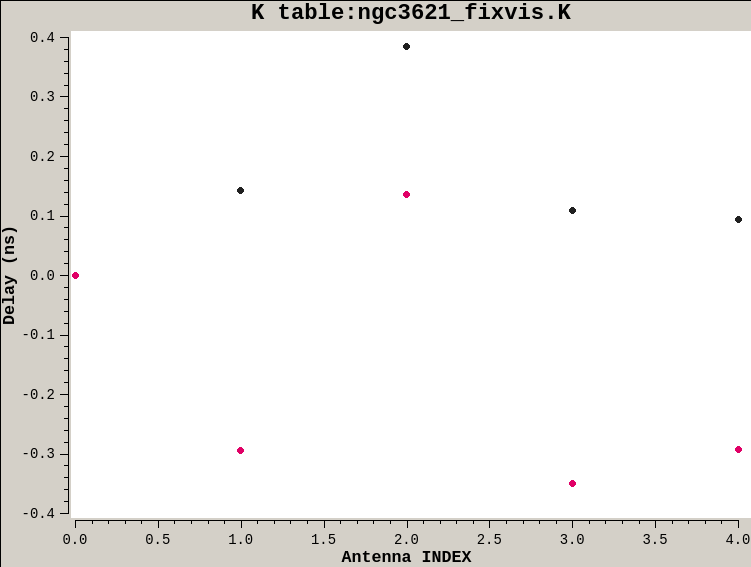

In [24]:
plotms(vis=ktable,
       title=f'K table:{ktable}',
       xlabel='Antenna INDEX',
       coloraxis='corr',
       showgui=False,
       plotfile='mkat_delaycal.png',
       overwrite=True,
       clearplots=True,
       )
Image('mkat_delaycal.png', height=500)

### Through away calibration using the flux cal
To stabilize time varying components, do a basic phase calibration

In [25]:
gtable0 = prefix + '.G0'

In [26]:
rmtables(gtable0)

In [27]:
gaincal(vis=msfile,
        caltable=gtable0,
        field=f_cal,
        solint='int',
        refant=ref_ant,
        gaintype='G',
        solnorm=True,
        calmode='p',
        minsnr=3.0,
        gaintable=[ktable])

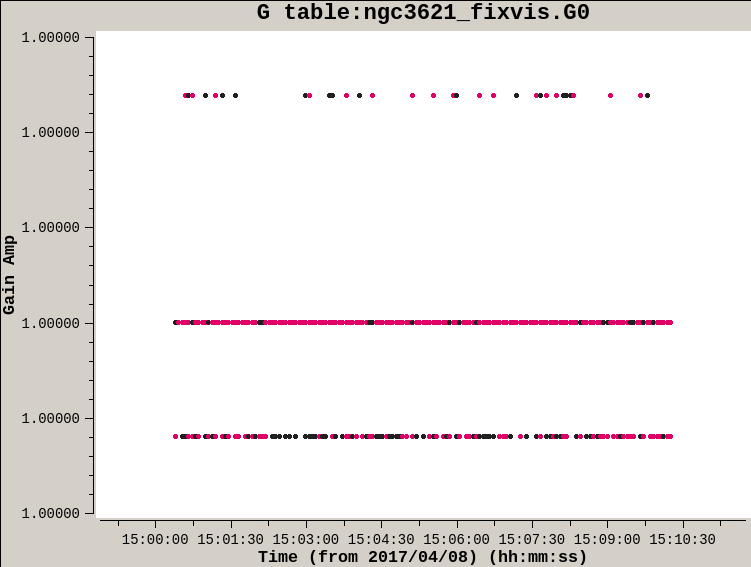

In [28]:
plotms(vis=gtable0,
       xaxis='time',
       yaxis='gainamp',
       title=f'G table:{gtable0}',
       coloraxis='corr',
       showgui=False,
       plotfile='mkat_gaincal.png',
       overwrite=True,
       clearplots=True,
       )
Image('mkat_gaincal.png', height=500)

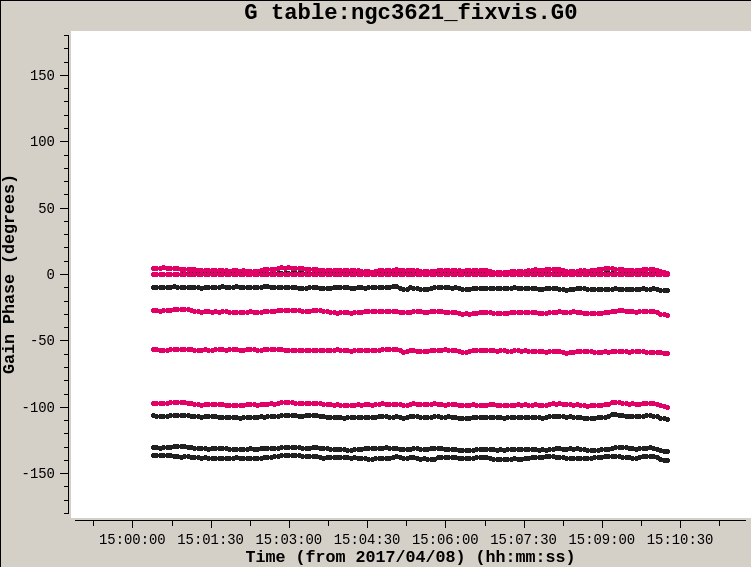

In [29]:
plotms(vis=gtable0,
       xaxis='time',
       yaxis='gainphase',
       title=f'G table:{gtable0}',
       plotrange = [-1, -1, -180, 180],
       coloraxis='corr',
       showgui=False,
       plotfile='mkat_gaincal.png',
       overwrite=True,
       clearplots=True,
       )
Image('mkat_gaincal.png', height=500)

### Solve for bandpass response using the flux cal

In [30]:
btable = prefix + '.B'

In [31]:
rmtables(btable)

In [32]:
bandpass(vis=msfile,
         caltable=btable,
         field=b_cal,
         refant=ref_ant,
         solnorm=True,
         combine='scan',
         solint='inf',
         bandtype='B',
         minsnr=3.0,
         gaintable=[gtable0, ktable])

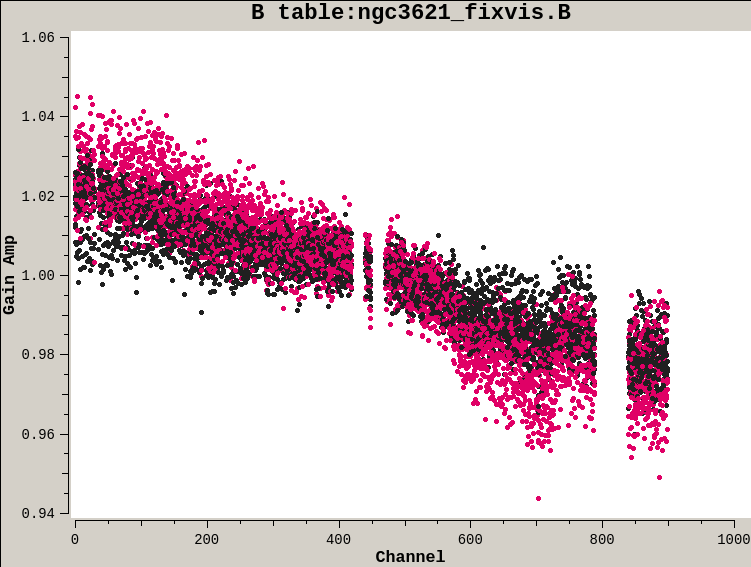

In [33]:
plotms(vis=btable,
       xaxis='chan',
       yaxis='gainamp',
       title=f'B table:{btable}',
       coloraxis='corr',
       showgui=False,
       plotfile='mkat_bpcal.png',
       overwrite=True,
       clearplots=True,
       )
Image('mkat_bpcal.png', height=500)

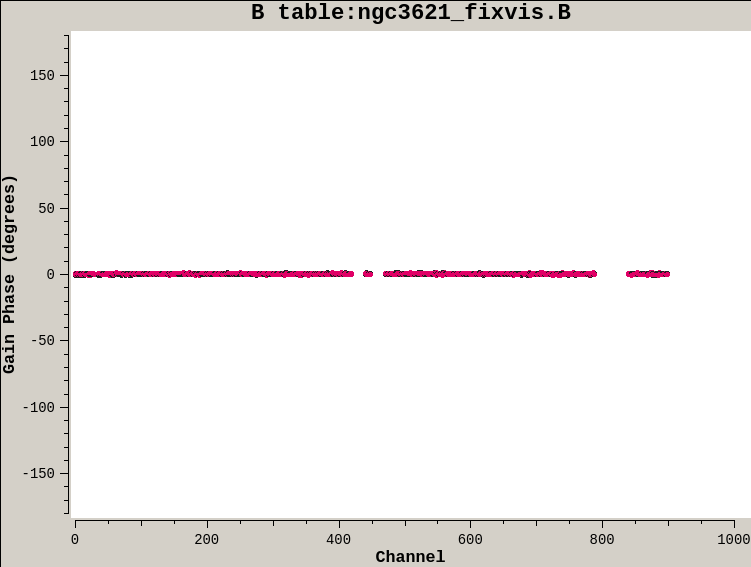

In [34]:
plotms(vis=btable,
       xaxis='chan',
       yaxis='gainphase',
       title=f'B table:{btable}',
       plotrange = [-1, -1, -180, 180],
       coloraxis='corr',
       showgui=False,
       plotfile='mkat_bpcal.png',
       overwrite=True,
       clearplots=True,
       )
Image('mkat_bpcal.png', height=500)

### Complex gain calibration

In [35]:
gtable = prefix + '.G'

In [36]:
rmtables(gtable)

In [37]:
gaincal(vis=msfile,
        caltable=gtable,
        field=f_cal,
        solint='int',
        refant=ref_ant,
        combine='spw',
        gaintype='G',
        calmode='ap',
        minsnr=1.0,
        solnorm=False,
        gaintable=[btable, ktable])

In [38]:
gaincal(vis=msfile,
        caltable=gtable,
        field=g_cal,
        solint='int',
        refant=ref_ant,
        combine='spw',
        gaintype='G',
        calmode='ap',
        minsnr=1.0,
        solnorm=False,
        append=True,
        gaintable=[btable, ktable])

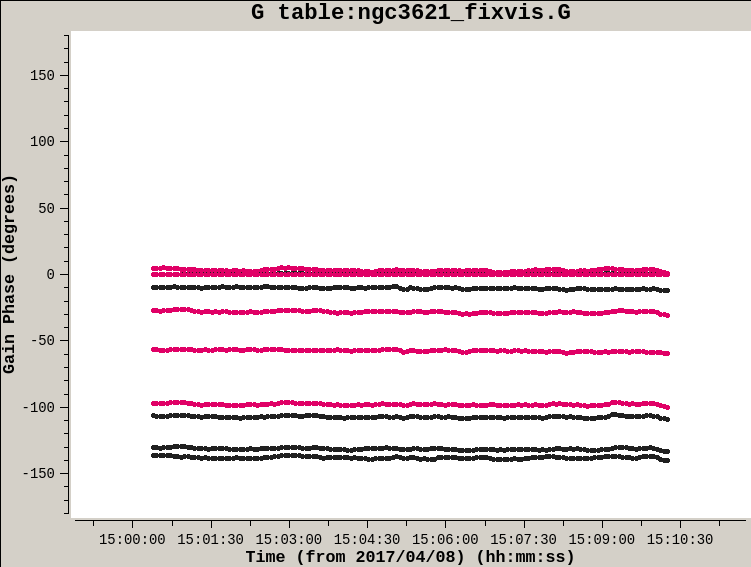

In [39]:
plotms(vis=gtable0,
       field=f_cal+','+g_cal,
       xaxis='time',
       yaxis='gainphase',
       title=f'G table:{gtable}',
       coloraxis='corr',
       plotrange = [-1, -1, -180, 180],
       showgui=False,
       plotfile='mkat_gaincal.png',
       overwrite=True,
       clearplots=True,
       )
Image('mkat_gaincal.png', height=500)

### Flux calibration

In [40]:
ftable = prefix + '.flux'

In [41]:
rmtables(ftable)

In [42]:
fluxscale(vis=msfile,
          caltable=gtable,
          fluxtable=ftable,
          reference=f_cal,
          transfer=g_cal)

{'2': {'0': {'fluxd': array([1.96640635, 0.        , 0.        , 0.        ]),
   'fluxdErr': array([0.04938857, 0.        , 0.        , 0.        ]),
   'numSol': array([10.,  0.,  0.,  0.])},
  'covarMat': array([], shape=(0, 0), dtype=float64),
  'fieldName': '1117-248',
  'fitFluxd': 1.9664063546452109,
  'fitFluxdErr': 0.0,
  'fitRefFreq': 1411101684.5703125,
  'spidx': array([0., 0.]),
  'spidxerr': array([0., 0.])},
 'freq': array([1.41110168e+09]),
 'spwID': array([0], dtype=int32),
 'spwName': array(['none'], dtype='<U16')}

### Apply calibration separately to each source

In [43]:
applycal(vis=msfile,
         field=f_cal,
         gaintable=[ftable, btable, ktable],
         gainfield=[f_cal, f_cal, f_cal],
         interp=['', 'nearest', ''],
         calwt=False,
         applymode='calflag')

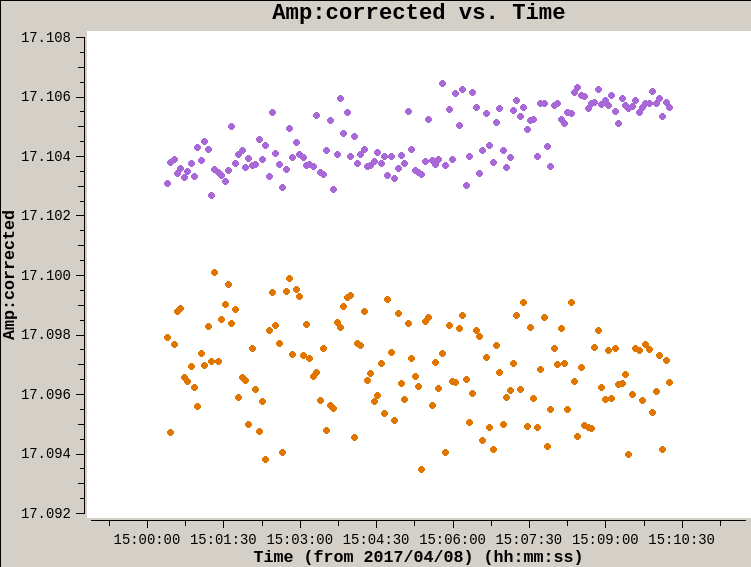

In [44]:
plotms(vis=msfile,
       xaxis='time',
       yaxis='amp',
       ydatacolumn='corrected',
       correlation='XX,YY',
       field=f_cal,
       coloraxis='corr',
       averagedata=True,
       avgbaseline=True,
       avgchannel='4096',
       showgui=False,
       plotfile='mkat_passband.png',
       overwrite=True,
       clearplots=True,
       )
Image('mkat_passband.png', height=500)

In [45]:
applycal(vis=msfile,
         field=g_cal,
         gaintable=[ftable, btable, ktable],
         gainfield=[g_cal, b_cal, f_cal],
         interp=['', 'nearest', ''],
         calwt=False,
         applymode='calflag')

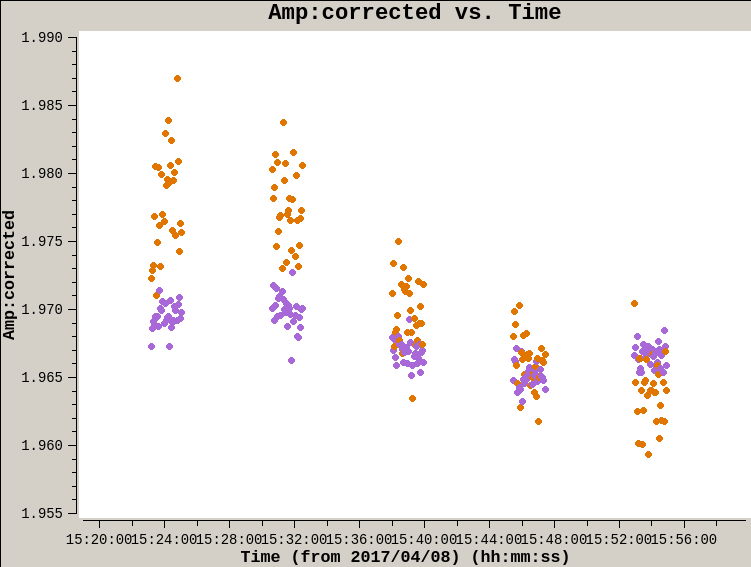

In [46]:
plotms(vis=msfile,
       xaxis='time',
       yaxis='amp',
       ydatacolumn='corrected',
       correlation='XX,YY',
       field=g_cal,
       coloraxis='corr',
       averagedata=True,
       avgbaseline=True,
       avgchannel='4096',
       showgui=False,
       plotfile='mkat_passband.png',
       overwrite=True,
       clearplots=True,
       )
Image('mkat_passband.png', height=500)

# Copy flagged data back to Google drive

In [ ]:
!tar -cvzf "ngc3621_calibrated.ms.tar.gz" "ngc3621.ms"

In [ ]:
!tar -tvzf "ngc3621_calibrated.ms.tar.gz"

**NOTE: update the path below to the appropriate directory in drive where you want to save the data**

In [49]:
!cp "ngc3621_calibrated.ms.tar.gz" "drive/MyDrive/ARIWS public datasets/output"